# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
epochs = 10
batch_size = 4
sequence_length = 256

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-text-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device
    set_seed(seed)

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            '1-FR': [y_train[i][0] for i in temp],
            '2-GI': [y_train[i][1] for i in temp],
            '3-PI': [y_train[i][2] for i in temp],
            '4-DM': [y_train[i][3] for i in temp],
            '5-EDTRB': [y_train[i][4] for i in temp],
            '6-RE': [y_train[i][5] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [15]:
def active_learning(seed, i, init_size):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'dat-random-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.738, Accuracy: 0.8542, F1 Micro: 0.8941, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6097, Accuracy: 0.8958, F1 Micro: 0.9245, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5531, Accuracy: 0.9439, F1 Micro: 0.9579, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.49, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4306, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.383, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3555, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3137, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2901, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5349, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2659, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1636, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1699, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1493, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1197, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1028,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4258, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1897, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.125, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1209, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1003, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 9/10, Train Loss: 0.1057, Accuracy: 0.9583, F1 Micro: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.373, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1547, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1403, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1252, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.116, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0915, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0669, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1419, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1364, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6517
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.9599, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3389, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1614, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1562, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1182, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9647, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3269, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1799, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1358, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7207
Epoch 9/10, Train Loss: 0.0628, Accuracy: 0.9599, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2832, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1544, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7182
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7517
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7011
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Epoch 10/10, Train Loss: 0.0533, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2886, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1396, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1249, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7198
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7185
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7011
Epoch 10/10, Train Loss: 0.0366, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2842, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1407, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.0616, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7332
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7334
Epoch 10/10, Train Loss: 0.0327, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2751, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1713, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1275, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6998
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2739, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0633, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7391
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 10/10, Train Loss: 0.0408, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1808, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1646, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.6509
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0792, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7296
Epoch 8/10, Train Loss: 0.0503, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.7035
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.786
Iteration 279: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2654, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1484, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1515, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1272, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.6539
Epoch 5/10, Train Loss: 0.0963, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7192
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.064, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7375
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7382
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7224
Epoch 9/10, Train Loss: 0.0327, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 10/10, Train Loss: 0.0269, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2767, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1461, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1274, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.9535, F1 Micro: 0.9651, F1 Macro: 0.728
Epoch 6/10, Train Loss: 0.0791, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7082
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0371, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.263, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1566, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.147, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0766, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.0415, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7375
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.249, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1536, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7239
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.063, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7258
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7258
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1602, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1335, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1293, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7093
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7208
Epoch 6/10, Train Loss: 0.0825, Accuracy: 0.9535, F1 Micro: 0.9648, F1 Macro: 0.6916
Epoch 7/10, Train Loss: 0.0529, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.735
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9599, F1 Micro: 0.9693, F1 Macro: 0.7194
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2529, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1569, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1363, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1273, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.652
Epoch 5/10, Train Loss: 0.1082, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.7034
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.734
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7224
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0267, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2622, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1606, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0814, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7371
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7249
Epoch 8/10, Train Loss: 0.0468, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7957
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2509, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1517, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1474, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1311, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.6522
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7204
Epoch 7/10, Train Loss: 0.049, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7248
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7256
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7207
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2451, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1449, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1443, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1262, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.0815, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7258
Epoch 6/10, Train Loss: 0.0699, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0379, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7215
Epoch 10/10, Train Loss: 0.0263, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2505, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1731, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.6994
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9599, F1 Micro: 0.9694, F1 Macro: 0.7261
Epoch 6/10, Train Loss: 0.0769, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0617, Accuracy: 0.9615, F1 Micro: 0.9706, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0406, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9663, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2385, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1672, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.653
Epoch 4/10, Train Loss: 0.118, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.6985
Epoch 5/10, Train Loss: 0.0894, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Epoch 6/10, Train Loss: 0.0588, Accuracy: 0.9535, F1 Micro: 0.9642, F1 Macro: 0.7151
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7264
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7292
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.786
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7931
Iteration 390: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2349, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.173, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 4/10, Train Loss: 0.1091, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0809, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.8025
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9583, F1 Micro: 0.9682, F1 Macro: 0.7297
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7214
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9647, F1 Micro: 0.9732, F1 M

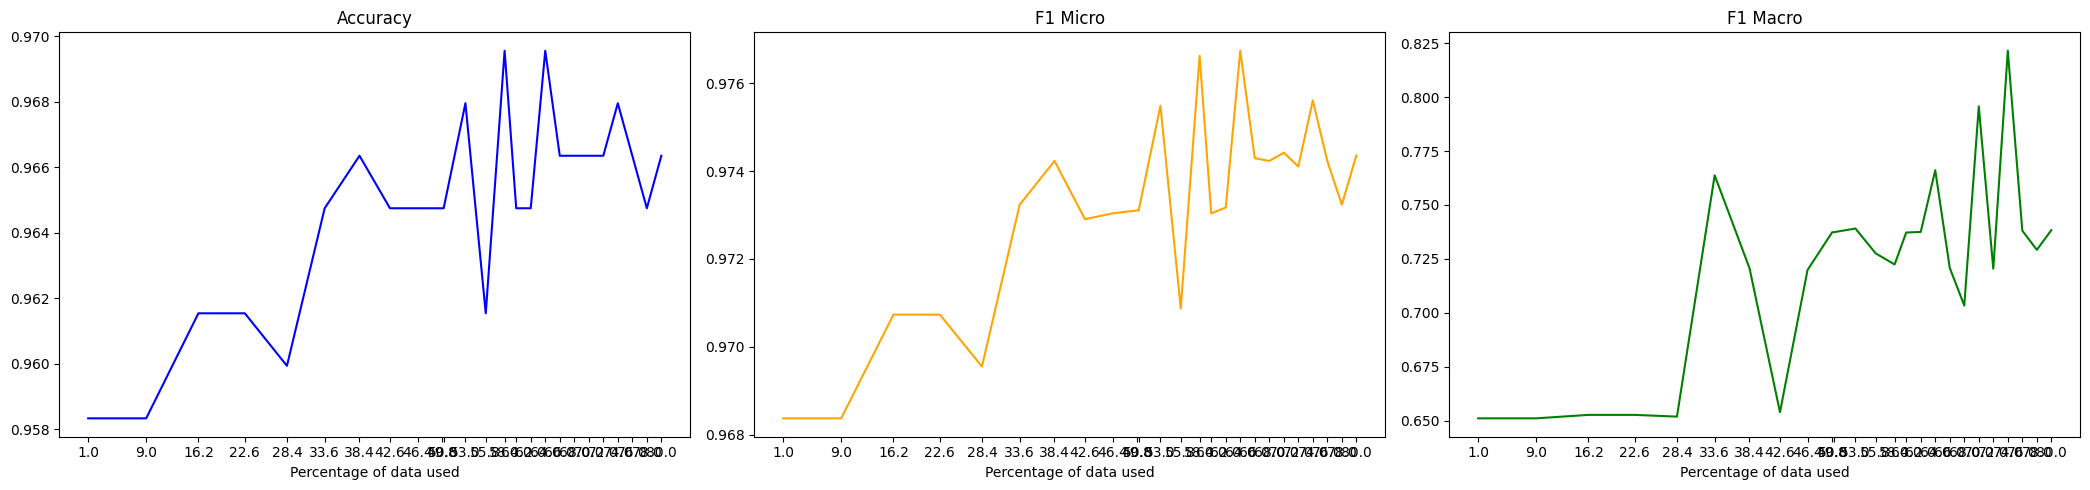

In [16]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 1)

Init Size 10
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5241, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3101, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2573, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1946, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1922, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1507, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1881, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1787, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1639,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4436, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2185, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1936, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1433, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1468, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1103, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1086,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3823, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2258, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1701, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1673, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1328, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 8/10, Train Loss: 0.096, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3445, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1674, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1493, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1153, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7066
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9535, F1 Micro: 0.965, F1 Macro: 0.7116
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0838, Accuracy: 0.9583, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3266, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1775, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7419
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.9551, F1 Micro: 0.9662, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.736
Epoch 10/10, Train Loss: 0.0376, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.314, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1785, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1499, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.13, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.6986
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7275
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7283
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9631, F1 Micro: 0.97

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2979, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1835, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7342
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0402, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7249
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2947, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1653, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1451, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1418, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7085
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0549, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7503
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7019
Epoch 10/10, Train Loss: 0.0354, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2906, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1529, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.148, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1274, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7177
Epoch 6/10, Train Loss: 0.0625, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7298
Epoch 7/10, Train Loss: 0.0628, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9615, F1 Micro: 0.9705, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7948
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2736, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1633, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1237, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1289, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7166
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.6967
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7003
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7289
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2569, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1587, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1631, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1305, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7267
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7201
Epoch 7/10, Train Loss: 0.0441, Accuracy: 0.9599, F1 Micro: 0.9692, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0451, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7217
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9503, F1 Micro: 0.962, F1 Macro: 0.7857
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.259, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1675, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1544, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.0944, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0758, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7383
Epoch 7/10, Train Loss: 0.0653, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7372
Epoch 8/10, Train Loss: 0.0395, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8033
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.8029
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2501, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1521, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1603, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1292, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0776, Accuracy: 0.9583, F1 Micro: 0.9685, F1 Macro: 0.7259
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0761, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7661
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 9/10, Train Loss: 0.0383, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8039
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2614, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.166, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1334, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1322, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.73
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7015
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7858
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7914
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2572, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1699, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1625, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1043, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7357
Epoch 6/10, Train Loss: 0.072, Accuracy: 0.9519, F1 Micro: 0.9639, F1 Macro: 0.7223
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.6983
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9519, F1 Micro: 0.9636, F1 Macro: 0.7061
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7955
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.9551, F1 Micro: 0.9661, F1 Macro: 0.778
Iteration 320: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1394, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0632, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.728
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.8033
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7332
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.7799
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2538, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1818, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1386, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Epoch 4/10, Train Loss: 0.1204, Accuracy: 0.9551, F1 Micro: 0.966, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0881, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0678, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.755
Epoch 7/10, Train Loss: 0.0505, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7266
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.8041
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9583, F1 Micro: 0.9686, F1 Macro: 0.8167
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2577, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1648, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.73
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9567, F1 Micro: 0.9674, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7945
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7949
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.8028
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.241, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1486, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1528, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0934, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0775, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.75
Epoch 7/10, Train Loss: 0.0562, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.803
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7946
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7942
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2565, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1558, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1561, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1288, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7468
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9631, F1 Micro: 0.9718, F1 Macro: 0.7362
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0282, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7503
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2442, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1637, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.113, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0932, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7368
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.7277
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7362
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9567, F1 Micro: 0.9671, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.8204
Epoch 10/10, Train Loss: 0.026, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2435, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1545, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1431, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6551
Epoch 4/10, Train Loss: 0.106, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.6958
Epoch 5/10, Train Loss: 0.0773, Accuracy: 0.9567, F1 Micro: 0.9672, F1 Macro: 0.7206
Epoch 6/10, Train Loss: 0.07, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7155
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7089
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9567, F1 Micro: 0.9673, F1 Macro: 0.7131
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9599, F1 Micro: 0.9696, F1 Macro: 0.7148
Iteration 390: Accuracy: 0.9663, F1 Micro: 0.9743, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2293, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1616, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.651
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1748, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1185, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7352
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0707, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7288
Epoch 7/10, Train Loss: 0.0502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9663, F1 Micro: 0

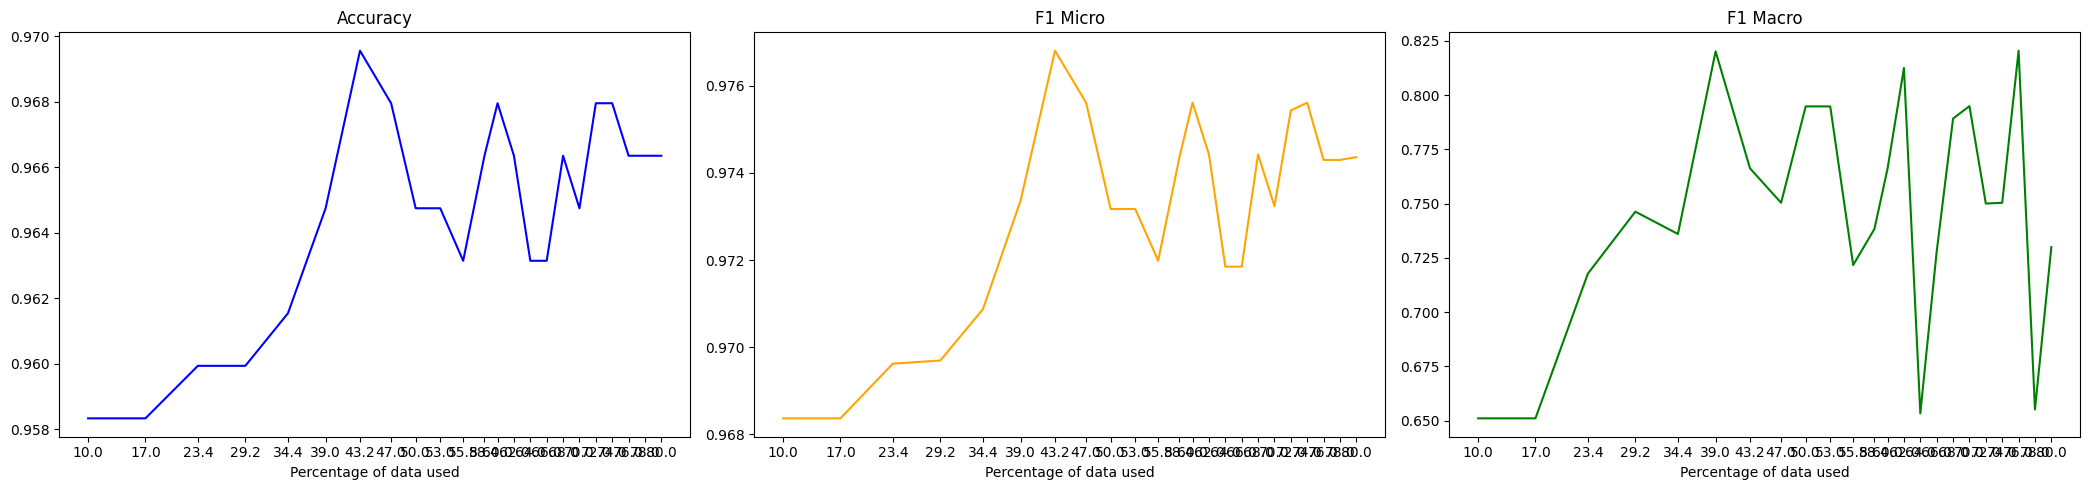

In [17]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 10)